## Develop an algorithm to efficiently assign vehicle occupants to nearby buildings.


Generating realistic building occupancy schedule in urban environments requires a comprehensive understanding of population dynamics, building locations and building size. Population dynamics and movement behavior in cities are modeled using agent based models. These models provide traces of vehicle locations at regular time intervals. Building footprints depict the spatial distribution of the buildings and their associated geometries.

In [1]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString

We zipped the multiple csv files from TRANSIMS in one folder and read it using pandas into one dataframe.

In [2]:
def read_gdf_from_zip(zip_fp):
    """
    Reads multiple csv files from ZipFile into a Pandas dataframe.
    """
    for zip_file in glob.glob(zip_fp):
        zf = zipfile.ZipFile(zip_file)
        dfs = [pd.read_csv(zf.open(f),sep=",") for f in zf.namelist()]
        sim_df = pd.concat(dfs,ignore_index=True)
    
    return sim_df

In [3]:
snapshot = read_gdf_from_zip('/Users/vsundar/Documents/personal/smc/data/vehicle_data/Simulation_Snapshot/snapshot.zip')

It is assumed that during a typical day, agents travel from a specific building near their origin location to a specific building near their destination location. 

Building occupancy at the start and end of the day can be calculated by assigning agents to buildings nearest to their origin (“first seen”) and destination (“last seen”) locations.

We prepare the two datasets describing the locations of the agents (start and end), assign geometry attributes and prescribe a coordinate reference system (CRS).

In [4]:
def start_end(sim_df):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    sim_snap_df = sim_df.groupby('VEHICLE')   
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    sim_end.X_COORD = pd.to_numeric(sim_end.X_COORD)
    sim_end.Y_COORD = pd.to_numeric(sim_end.Y_COORD)
    sim_start.X_COORD = pd.to_numeric(sim_start.X_COORD)
    sim_start.Y_COORD = pd.to_numeric(sim_start.Y_COORD)
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    sim_start_wgs84 = sim_start_gdf.to_crs(epsg=4326)
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    sim_end_wgs84 = sim_end_gdf.to_crs(epsg=4326)
    sim_start_wgs84 = sim_start_wgs84.reset_index(drop=True)
    
    return sim_start_wgs84, sim_end_wgs84

In [5]:
import time
start_time = time.time()
sim_start,sim_end = start_end(snapshot)
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.30513310432434 seconds ---


We assigned a CRS to the building data, calculated centroids and the relative area of each building.

In [6]:
def building_prep(building_map:str):
    """ 
    Reads building geojson and prepares building data for calculating nearest distance metrics.
    """
    building_map = gpd.read_file(building_map)
    building_map = building_map.assign(centroid=building_map.centroid)
    building_map.crs="EPSG:4326"
    building_map = building_map.to_crs(epsg=26916)
    building_map["footprint_area"] = building_map.geometry.area
    ##Calculate relative area to obtain weighted distance measures
#     building_map["relative_area"] = (building_map.footprint_area)/(building_map.footprint_area.sum())
    building_map = building_map.to_crs(epsg=4326)
    
    return building_map

Agent dataset covers a larger spatial extent compared to the building dataset (Figure 1). The agents dataset was clipped to within 1000 m of the building footprints. 

In [7]:
##Get rid of multi polygons
building_map = building_prep(building_map= "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/Building_Footprints/ChicagoLoop_attr.geojson")
building_map_proc = building_map.drop_duplicates(subset='centroid', keep="last")
building_map_proc=building_map_proc.reset_index(drop=True)
building_map_proc['building_id'] = building_map_proc.index

In [8]:
## Read a building mask and clip the agents
building_mask = "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/building_mask/building_mask_buff.shp"
building_mask = gpd.read_file(building_mask)
sim_start_clip = gpd.overlay(sim_start,building_mask)
sim_end_clip = gpd.overlay(sim_end,building_mask)


In [9]:
sim_start_clip

,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD,id,geometry
0,245126,0:00:30,526,0,1,75.0,15.0,0.0,1,24512601,0,447472.067970,4.637343e+06,1,POINT (-87.63313 41.88627)
1,166155,2:40,57,0,3,112.5,0.0,-30.0,1,16615501,0,447573.359857,4.636864e+06,1,POINT (-87.63187 41.88196)
2,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,0,446824.617870,4.636856e+06,1,POINT (-87.64089 41.88185)
3,202723,2:47:30,139,1,3,67.5,7.5,-7.5,1,20272301,0,447741.477250,4.635920e+06,1,POINT (-87.62976 41.87347)
4,241483,2:47:30,527,0,1,120.0,7.5,7.5,1,24148301,0,447315.850742,4.637344e+06,1,POINT (-87.63502 41.88627)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100436,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,0,447608.505670,4.634674e+06,1,POINT (-87.63125 41.86224)
100437,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,0,447605.849683,4.634810e+06,1,POINT (-87.63130 41.86347)
100438,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,0,447600.676242,4.636580e+06,1,POINT (-87.63151 41.87941)
100439,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,0,447603.193859,4.634946e+06,1,POINT (-87.63134 41.86469)


<IPython.core.display.Javascript object>


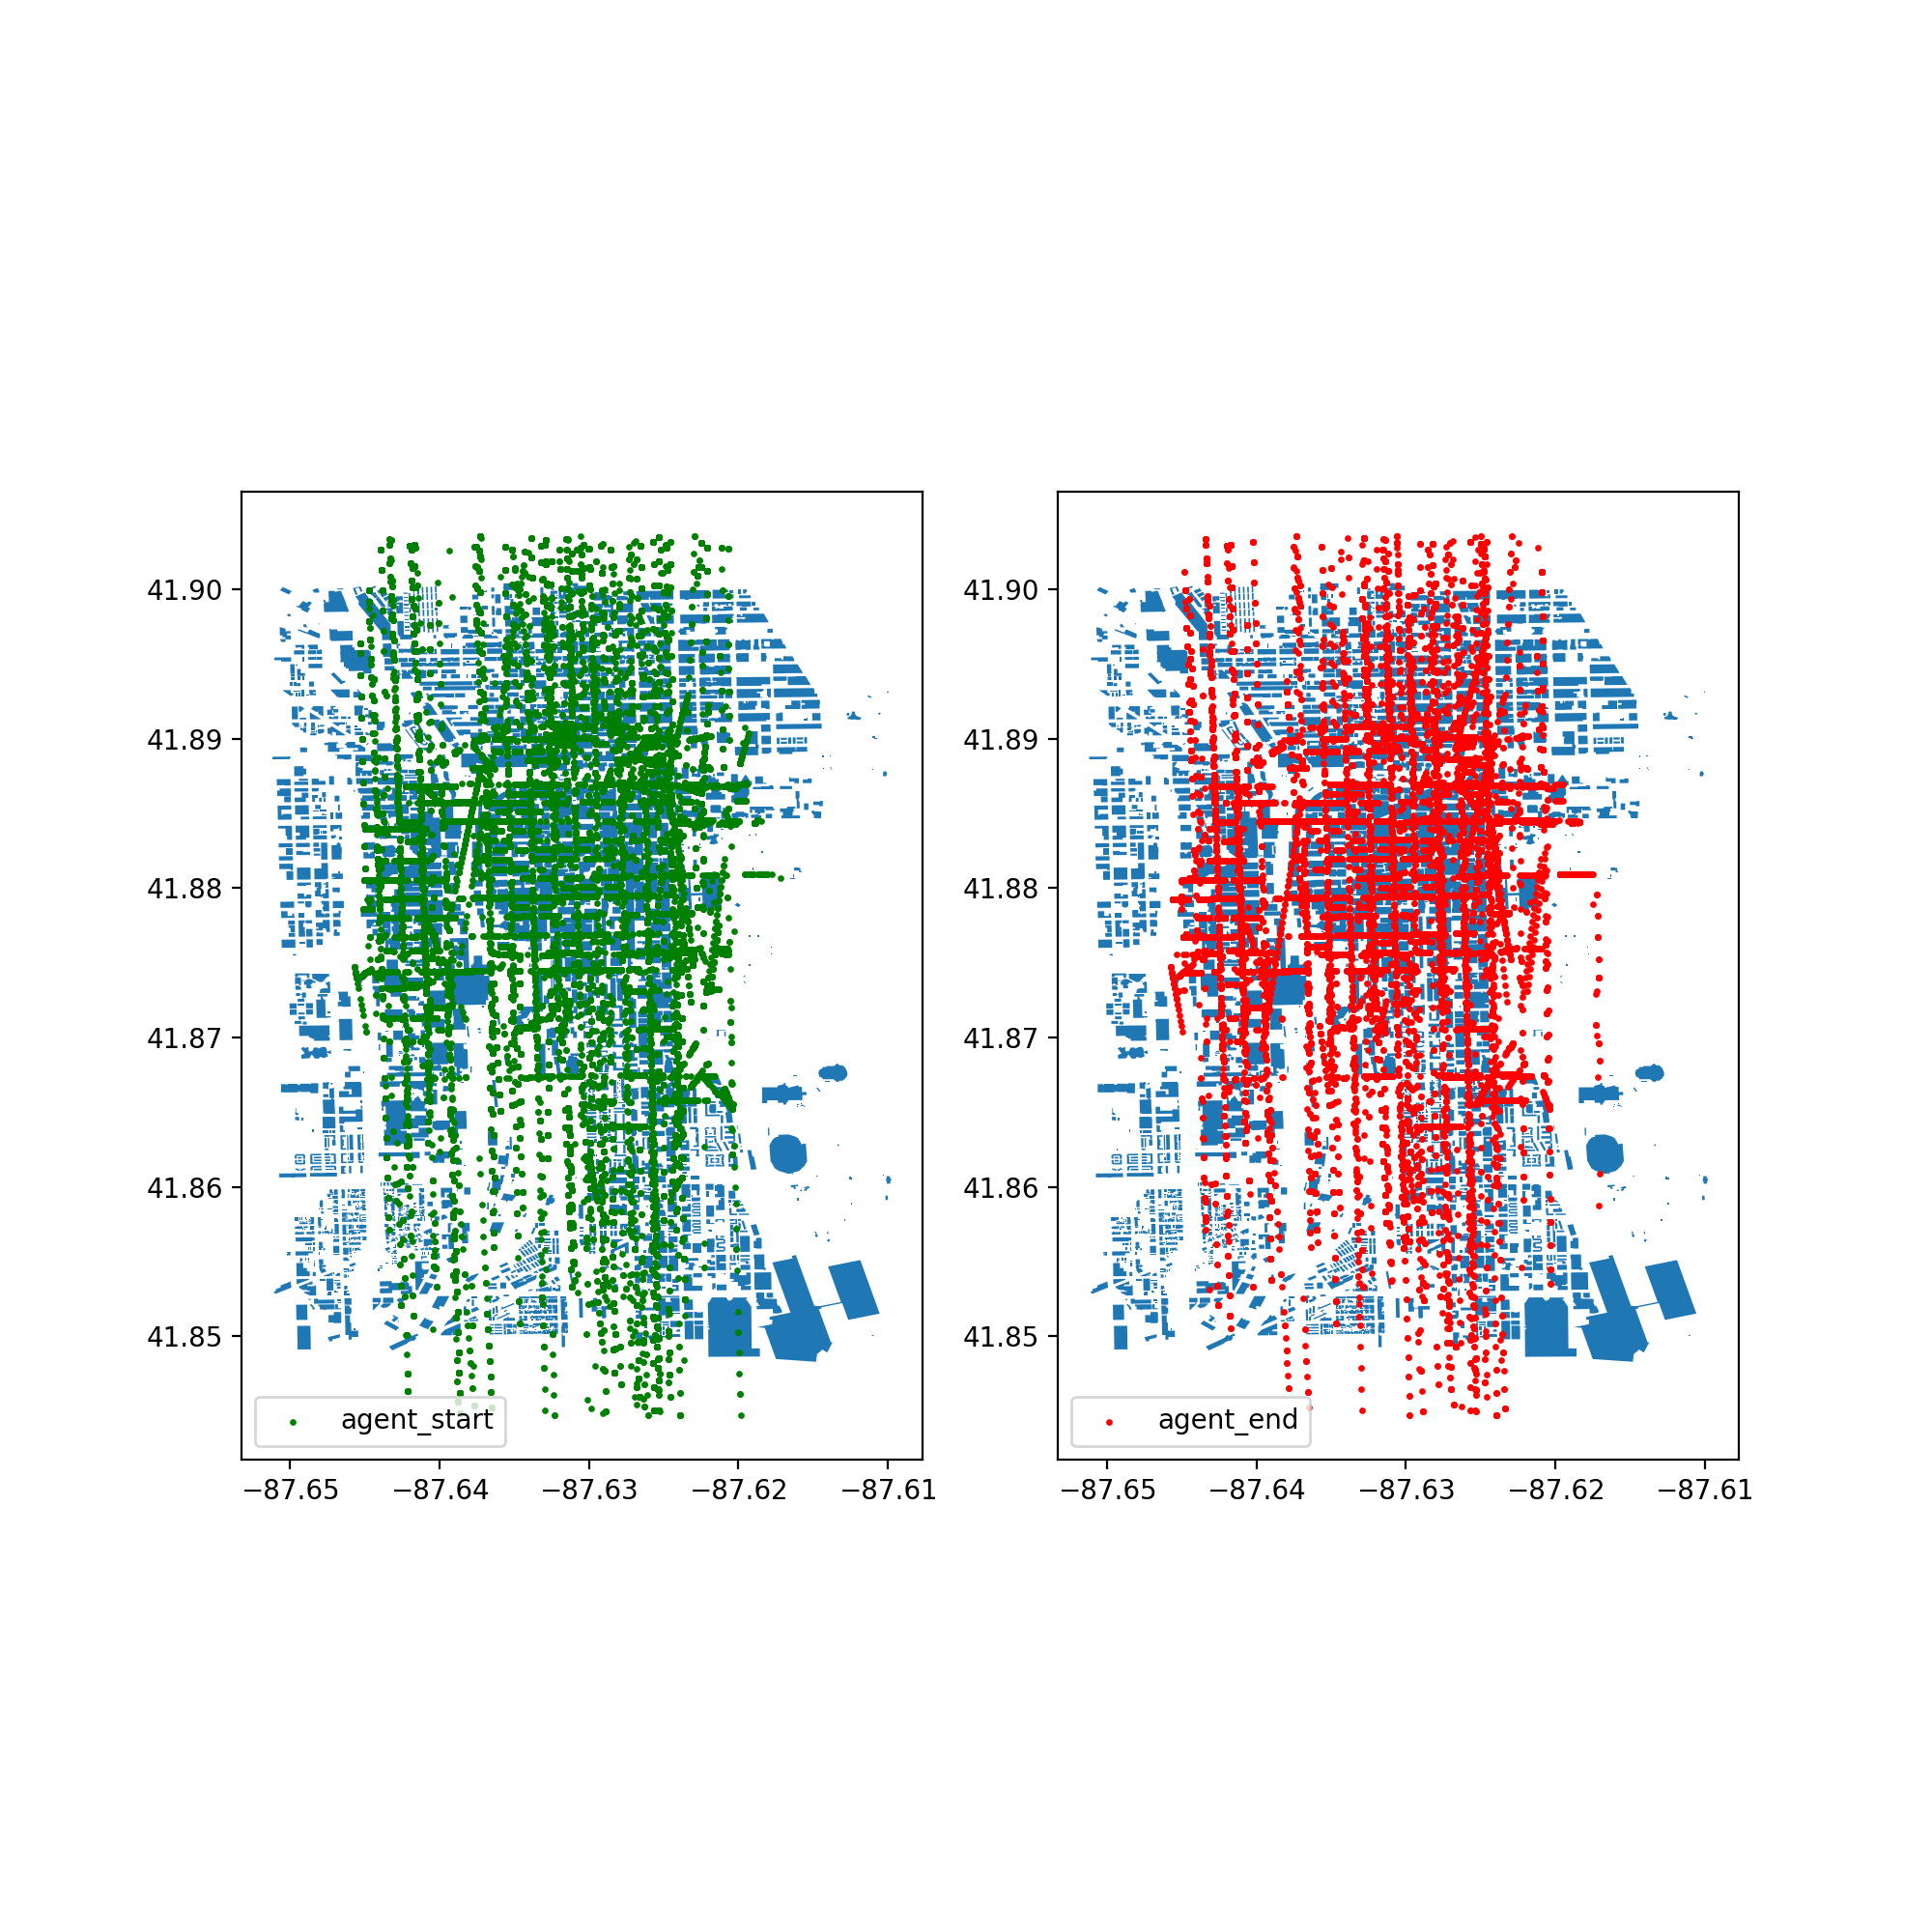

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(10,10))
# Plot buildings and start and  
building_map_proc.plot(ax=ax1)
building_map_proc.plot(ax=ax2)
sim_start_clip.plot(ax=ax1, marker='o', color='Green', markersize=2,label='agent_start')
sim_end_clip.plot(ax=ax2, marker='o', color='red', markersize=2,label='agent_end')
minx, miny, maxx, maxy = building_map.geometry.total_bounds
# # Margin around total bounds
# ax1.set_xlim(minx - 0.003, maxx + 0.003)
# ax1.set_ylim(minx - 0.003, maxx + 0.003)
# ax2.set_xlim(miny - 0.003, maxy + 0.003)
# ax2.set_ylim(miny - 0.003, maxy + 0.003)
ax1.legend(loc='best')
ax2.legend(loc='best')

In [11]:
from sklearn.neighbors import BallTree
import numpy as np

In [12]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=10, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [14]:
def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTE: Input points are in wgs84.
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.centroid

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
#     # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right_geom_col.apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [15]:
import time
start_time = time.time()
closest_buildings_start = nearest_neighbor(sim_start_clip, building_map_proc, return_dist=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.890275001525879 seconds ---


In [16]:
import time
start_time = time.time()
closest_buildings_end = nearest_neighbor(sim_end_clip, building_map_proc, return_dist=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.9186627864837646 seconds ---


In [17]:
# Rename the geometry of closest stops gdf so that we can easily identify
closest_buildings_start = closest_buildings_start.rename(columns={'centroid': 'closest_building_centroid'})
# #remove the 'geometry' polygon column
closest_buildings_st = closest_buildings_start.drop(columns=['geometry']) #polygon
# closest_buildings=closest_buildings.drop(columns=['Unnamed: 0'])
# #Merge the datasets by index (for this, it is good to use '.join()' -function)
sim_start_join = sim_start_clip.join(closest_buildings_st)

###Simulation end
closest_buildings_end = closest_buildings_end.rename(columns={'centroid': 'closest_building_centroid'})
closest_buildings_en = closest_buildings_end.drop(columns=['geometry']) #polygon
# closest_buildings=closest_buildings.drop(columns=['Unnamed: 0'])
# #Merge the datasets by index (for this, it is good to use '.join()' -function)
sim_end_join = sim_end_clip.join(closest_buildings_en)


In [18]:
# Create a link (LineString) between building and stop points
sim_start_join['link'] = sim_start_join.apply(lambda row: LineString([row['geometry'], row['closest_building_centroid']]), axis=1)
# Set link as the active geometry
building_links_start = sim_start_join.copy()
building_links_start = building_links_start.set_geometry('link')
# building_links.groupby('building_id').count()
building_agents_start = building_links_start.groupby(['building_id','footprint_area']).count()
building_agents_start.drop(building_agents_start.columns.difference(['building_id','footprint_area','VEHICLE']), 1, inplace=True)
building_agents_start = building_agents_start.rename(columns={'VEHICLE':'count'})
building_agents_geom_start = building_agents_start.join(building_map_proc,on='building_id')

###End 
sim_end_join['link'] = sim_end_join.apply(lambda row: LineString([row['geometry'], row['closest_building_centroid']]), axis=1)
# Set link as the active geometry
building_links_end = sim_end_join.copy()
building_links_end = building_links_end.set_geometry('link')
# building_links.groupby('building_id').count()
building_agents_end = building_links_end.groupby(['building_id','footprint_area']).count()
building_agents_end.drop(building_agents_end.columns.difference(['building_id','footprint_area','VEHICLE']), 1, inplace=True)
building_agents_end = building_agents_end.rename(columns={'VEHICLE':'count'})
building_agents_geom_end = building_agents_end.join(building_map_proc,on='building_id')


<IPython.core.display.Javascript object>


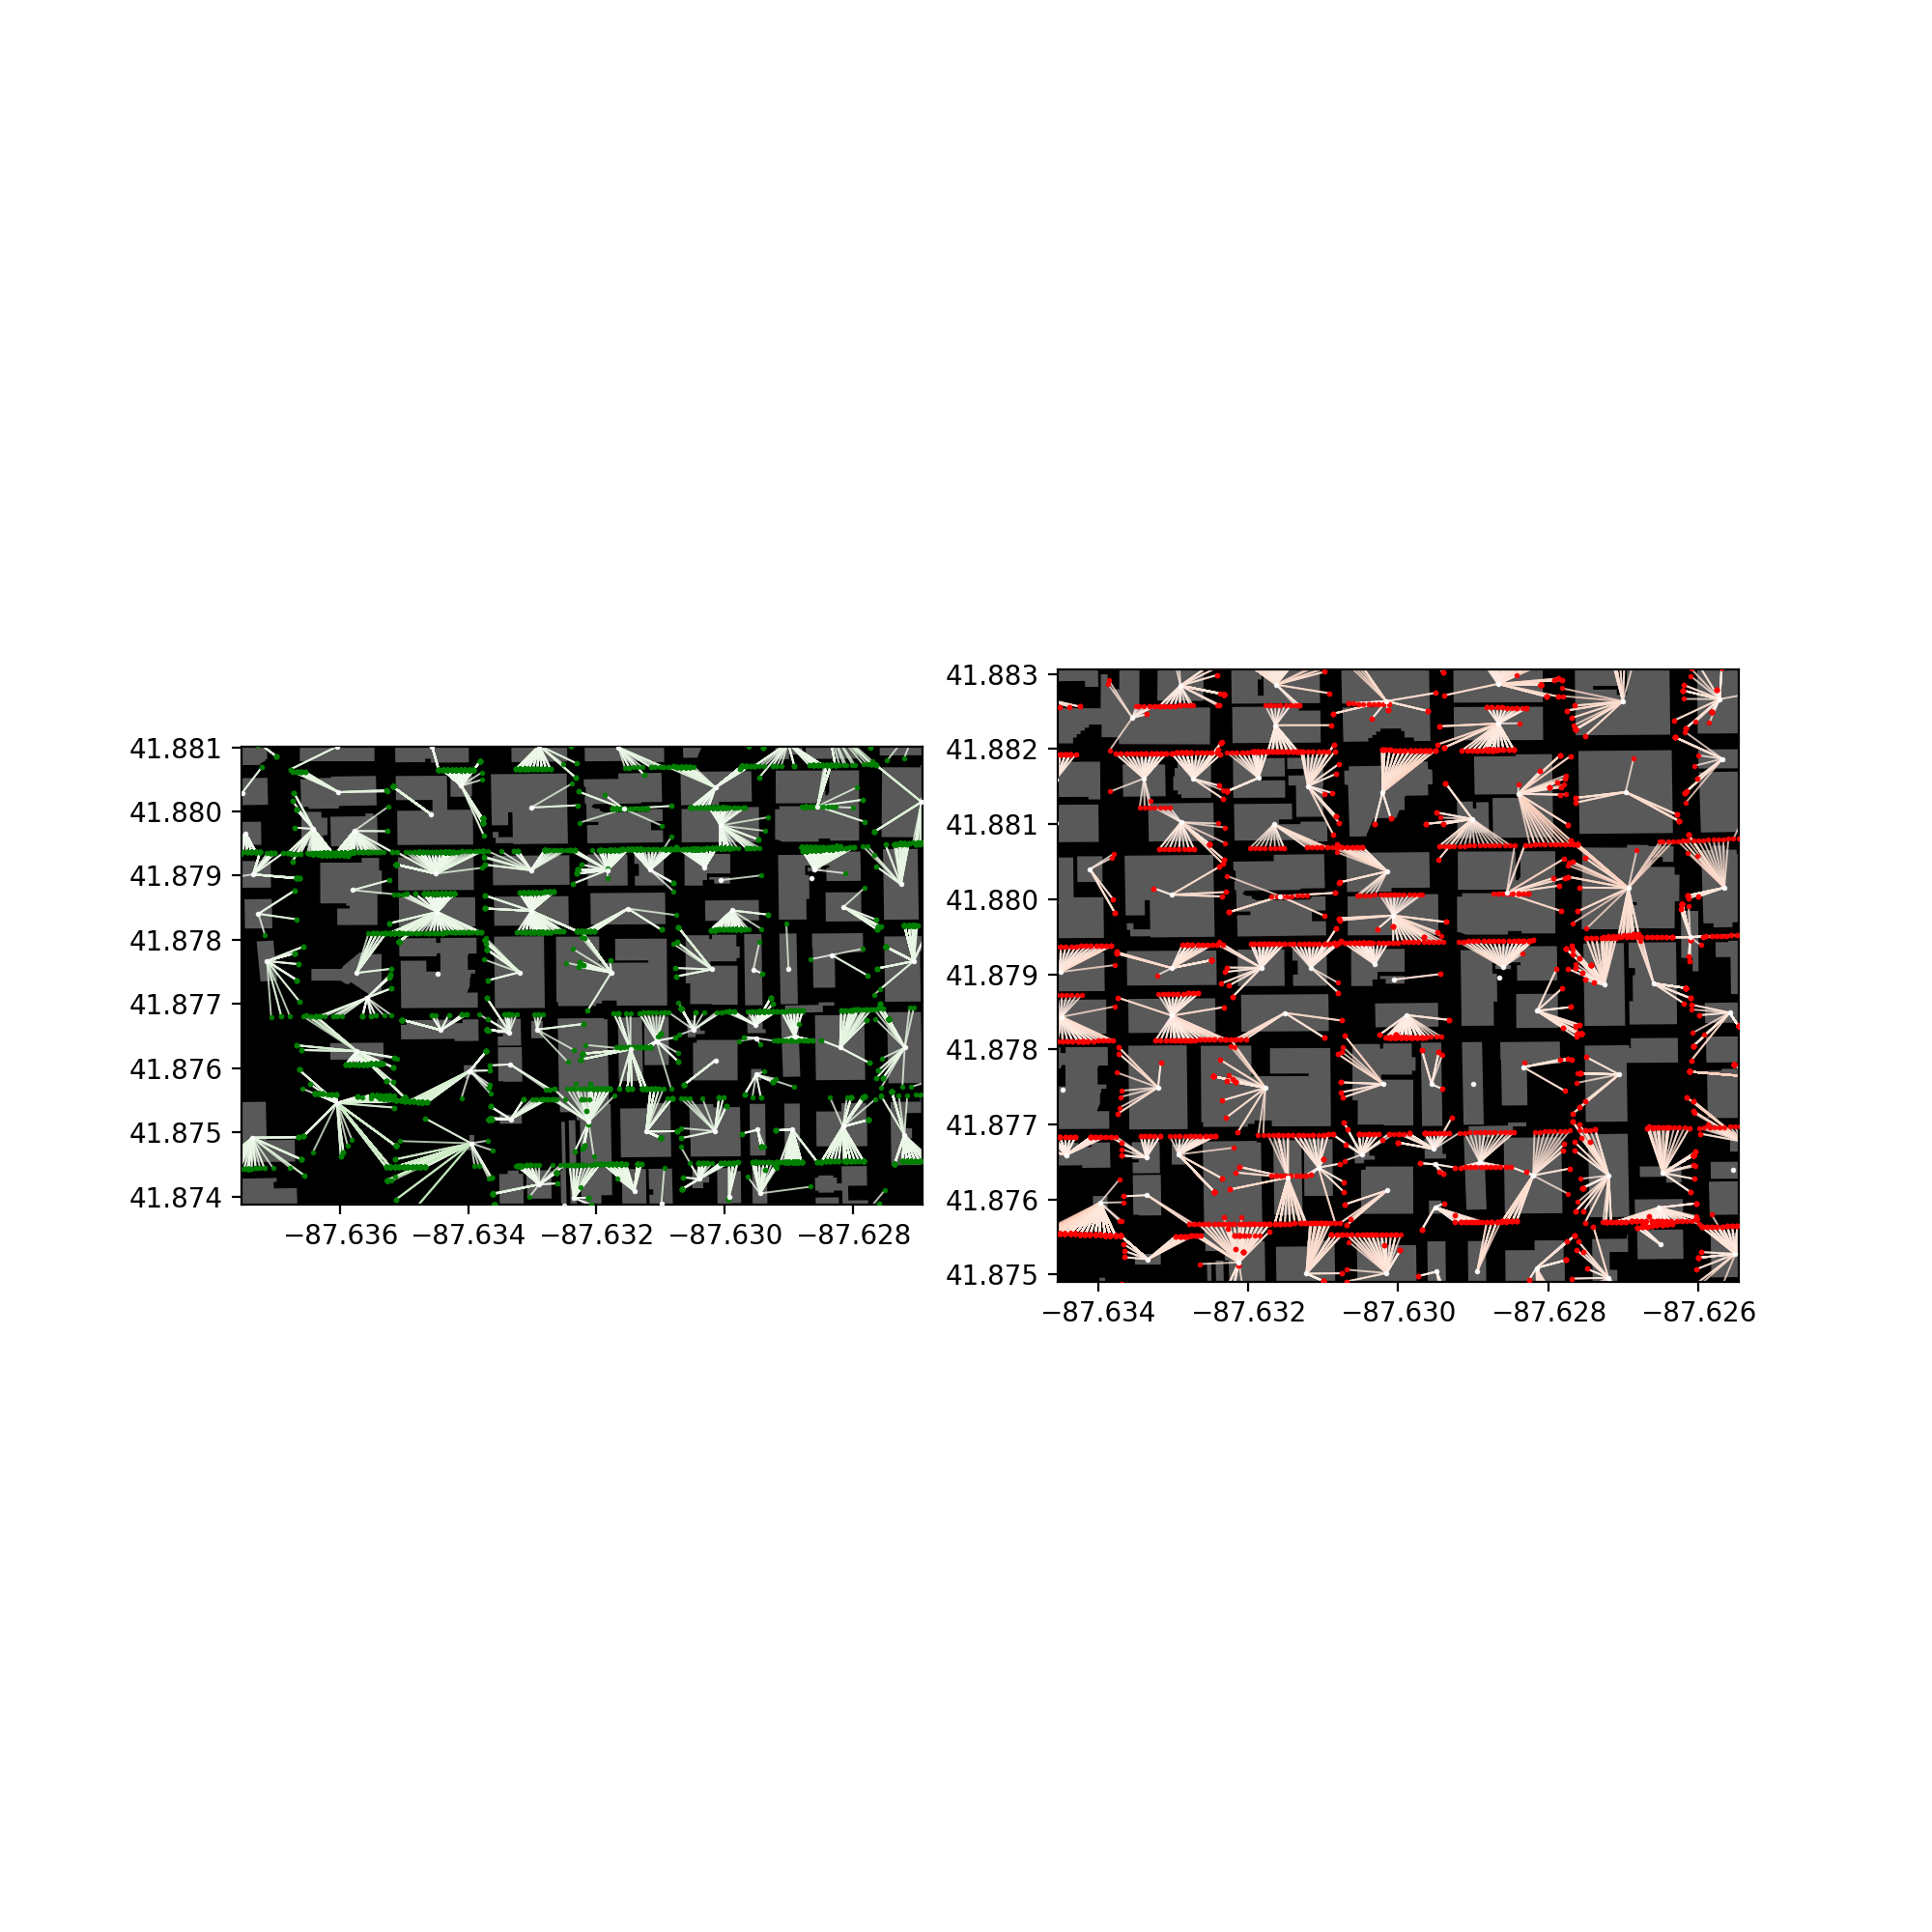

In [19]:
###Plot
%matplotlib notebook
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(10,10))
ax1 = building_links_start.plot(ax=ax1,column='distance', cmap='Greens', k=4, alpha=0.8, lw=0.7, figsize=(20,20))
ax1 = building_map_proc.plot(ax=ax1, color='gray', markersize=1, alpha=0.7)
ax1 = sim_start_join.plot(ax=ax1, markersize=1, marker='o', color='green', alpha=0.9, zorder=3)
ax1 = building_map_proc.centroid.plot(ax=ax1, markersize=1, marker='o', color='white', alpha=0.9, zorder=3)
# Zoom closer
#ax.set_xlim([24.99, 25.01])
#ax.set_ylim([])
# Set map background color to black, which helps with contrast
ax1.set_facecolor('black')

ax2 = building_links_end.plot(ax=ax2,column='distance', cmap='Reds', k=4, alpha=0.8, lw=0.7, figsize=(20,20))
ax2 = building_map_proc.plot(ax=ax2, color='gray', markersize=1, alpha=0.7)
ax2 = sim_end_join.plot(ax=ax2, markersize=1, marker='o', color='red', alpha=0.9, zorder=3)
ax2 = building_map_proc.centroid.plot(ax=ax2, markersize=1, marker='o', color='white', alpha=0.9, zorder=3)
# Zoom closer
#ax.set_xlim([24.99, 25.01])
#ax.set_ylim([])
# Set map background color to black, which helps with contrast
ax2.set_facecolor('black')


<IPython.core.display.Javascript object>


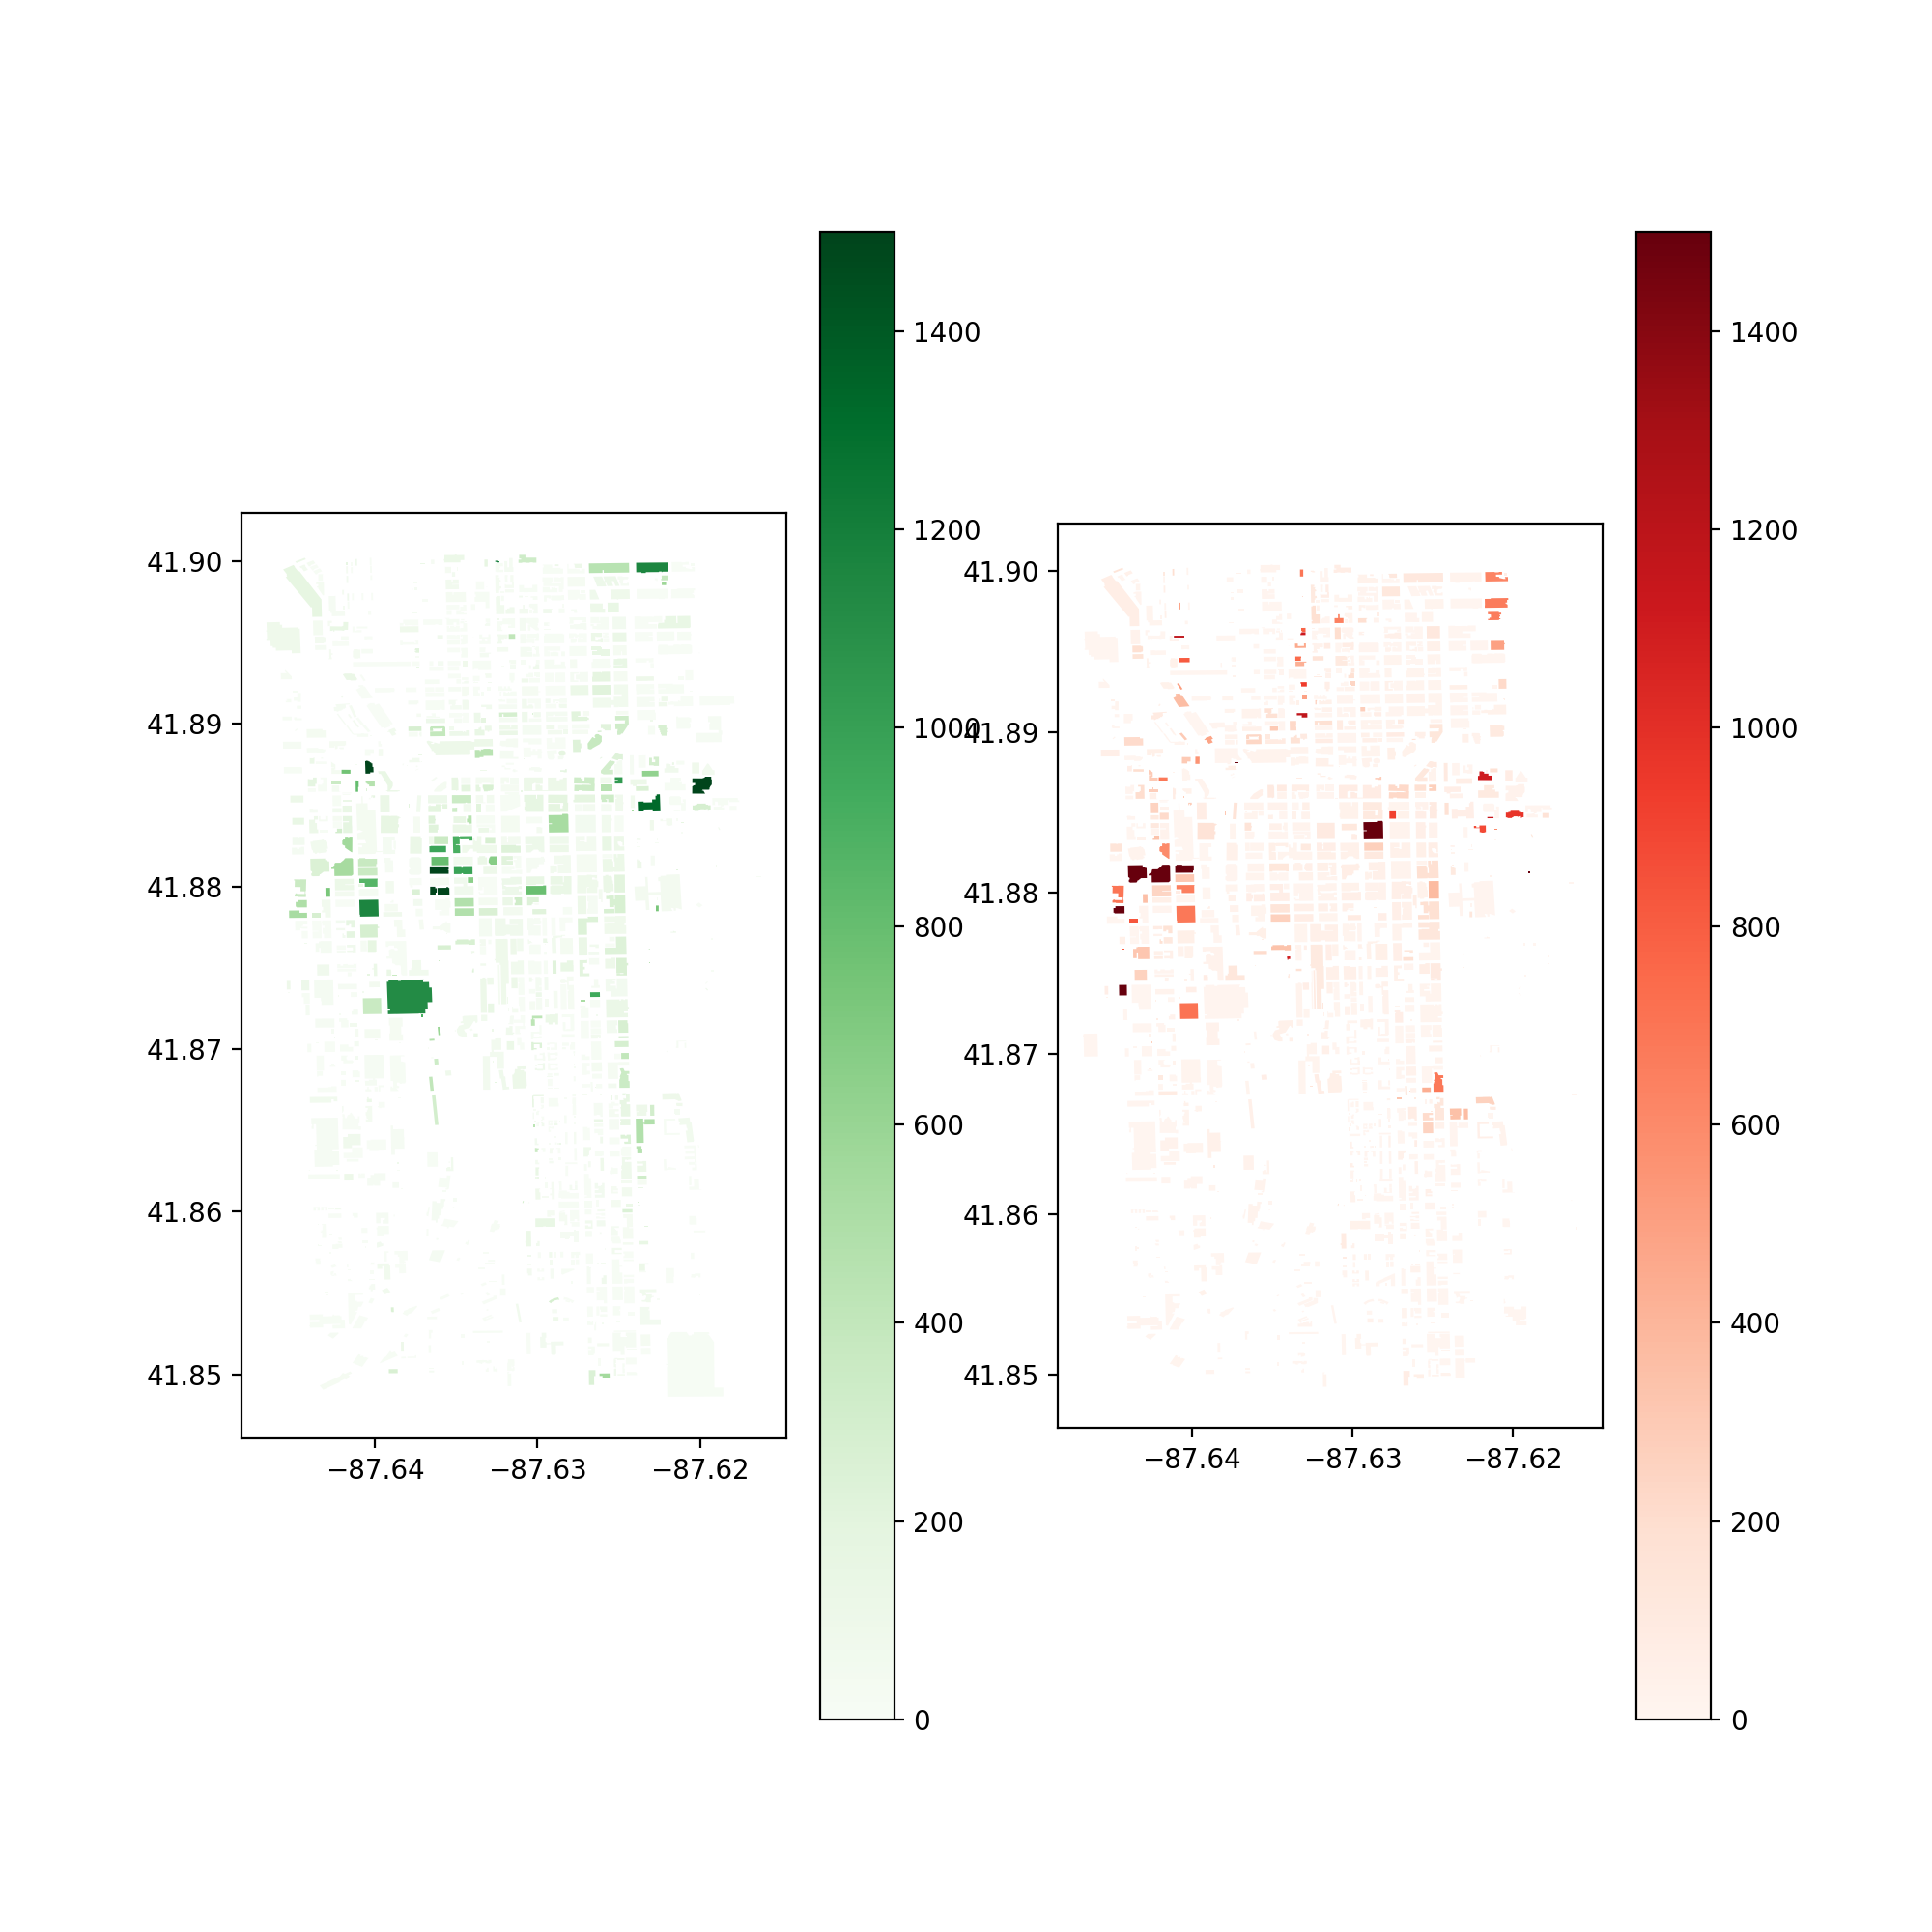

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

building_agents_geom_start.reset_index(drop=True)
building_agents_geom_start = gpd.GeoDataFrame(building_agents_geom_start)
building_agents_geom_start.crs="EPSG:4326"
building_agents_geom_start.plot(ax=ax1,column='count', cmap='Greens',legend=True,vmin=0,vmax=1500)

building_agents_geom_end.reset_index(drop=True)
building_agents_geom_end = gpd.GeoDataFrame(building_agents_geom_end)
building_agents_geom_end.crs="EPSG:4326"
building_agents_geom_end.plot(ax=ax2,column='count', cmap='Reds',legend=True,vmin=0,vmax=1500)


In [64]:
# building_agents_geom_end['count'].max().index()

building_agents_geom_end.iloc[building_agents_geom_end['count'].argmax()]

count                                                         10229
area                                                    1.37279e-08
perimeter                                                  0.000488
geometry          POLYGON ((-87.618966 41.881362, -87.6190540000...
centroid               POINT (-87.61900999999999 41.88128400000001)
footprint_area                                              126.471
building_id                                                     809
Name: (809, 126.47078651890136), dtype: object

In [84]:
building_agents_geom_end['count'].sort_values(ascending=False)

building_id  footprint_area
809          126.470787        10229
2321         2698.943131        8537
1934         9707.516150        6018
2267         12101.778554       4305
1878         10358.985139       3870
                               ...  
263          432.691259            1
259          924.250999            1
1227         2988.327677           1
1721         977.425142            1
1718         6570.648604           1
Name: count, Length: 1106, dtype: int64

<IPython.core.display.Javascript object>


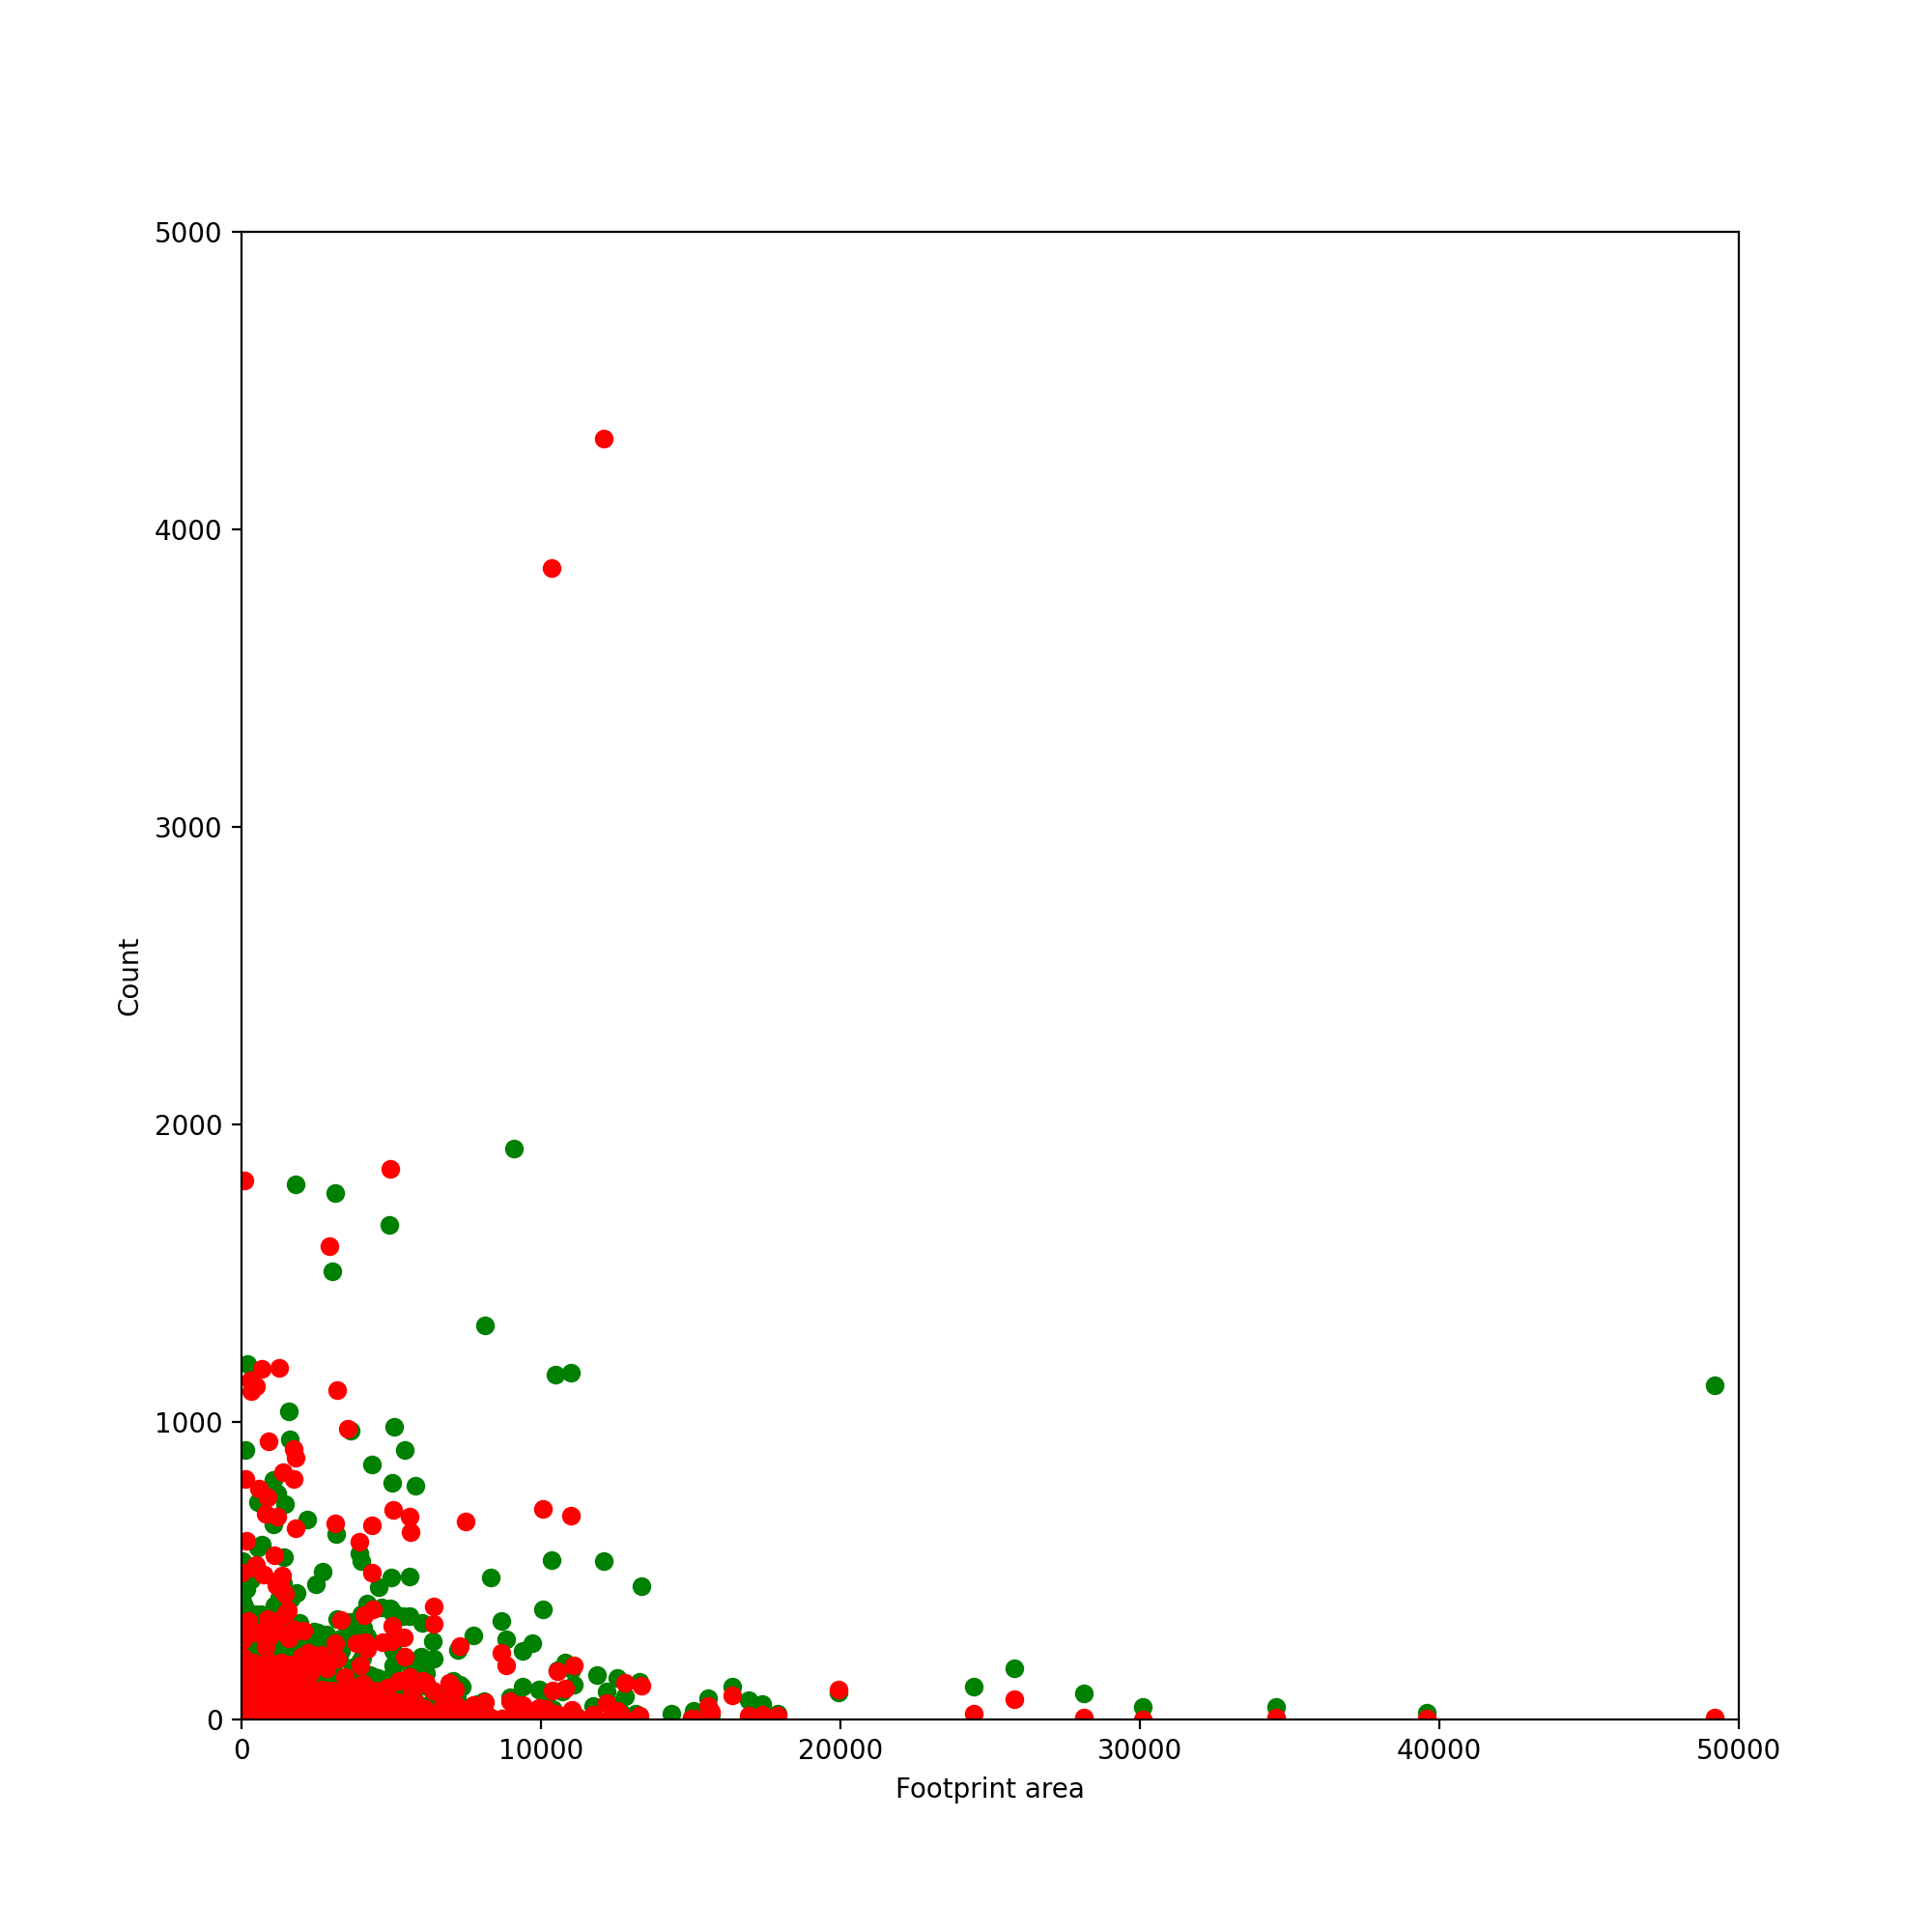

(0.0, 5000.0)

In [22]:
%matplotlib notebook
fig, ax  = plt.subplots (figsize = (10,10))
# bins_list = [0, 250, 500, 750, 1000, 1250, 1500] 
# building_agents_geom_end[["count","footprint_area"]].plot(kind="bar")
plt.scatter(building_agents_geom_start["footprint_area"],building_agents_geom_start["count"],color="green")
plt.scatter(building_agents_geom_end["footprint_area"],building_agents_geom_end["count"],color="red")
ax.set_xlabel("Footprint area")
ax.set_ylabel("Count")
ax.set_xlim([0,50000])
ax.set_ylim([0,5000])